Импорт библиотек

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import random
import pickle
from sklearn.model_selection import train_test_split
# from torchvision import transforms, datasets, models
# from torch.utils.data import DataLoader
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Загрузка датасета

In [13]:
DATASET_PATH = 'flowers'
IMAGE_SIZE = (224, 224)

def load_image_paths(dataset_path):
    image_paths = []
    for root, _, files in os.walk(dataset_path):
        for f in files:
            if f.lower().endswith('.jpg'):
                image_paths.append(os.path.join(root, f))
    return image_paths

image_paths = load_image_paths(DATASET_PATH)
print(f"Total images found: {len(image_paths)}")

Total images found: 4317


Загружаем ResNet50 без последнего слоя

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

In [ ]:
features_list = []

for img_path in image_paths:
    try:
        features = extract_features(img_path, model)
        features_list.append(features)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

features_array = np.array(features_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [19]:
np.save('embeddings.npy', features_array)
np.save('image_paths.npy', image_paths)


with open('embeddings.pkl', 'wb') as f:
    pickle.dump(features_array, f)

with open('image_paths.pkl', 'wb') as f:
    pickle.dump(image_paths, f)

In [20]:
def find_similar_images(input_img_path, model, features_array, image_paths, top_n=5):
    input_features = extract_features(input_img_path, model)
    input_features = input_features.reshape(1, -1)

    similarities = cosine_similarity(input_features, features_array).flatten()
    indices = np.argsort(similarities)[::-1][:top_n]  # по убыванию

    results = {}
    for idx in indices:
        results[image_paths[idx]] = float(similarities[idx])
    return results


Searching for: flowers\dandelion\151385302_f8980a257f_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


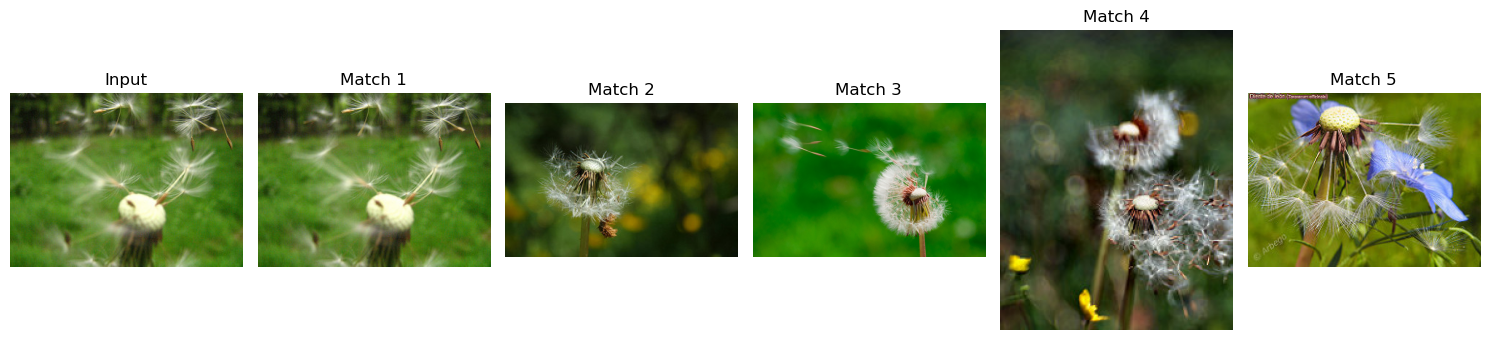


Searching for: flowers\daisy\2213954589_c7da4b1486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


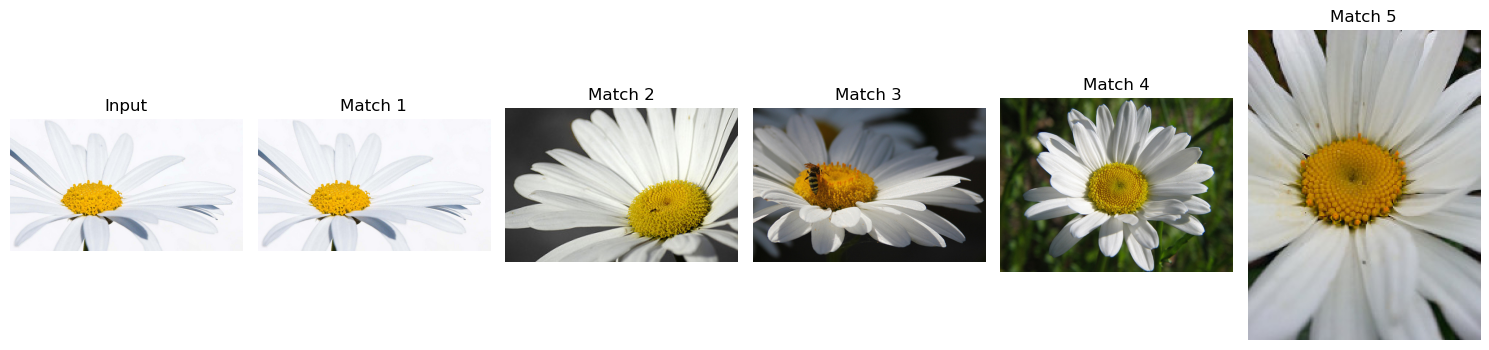


Searching for: flowers\rose\5001845289_e5740889b0_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


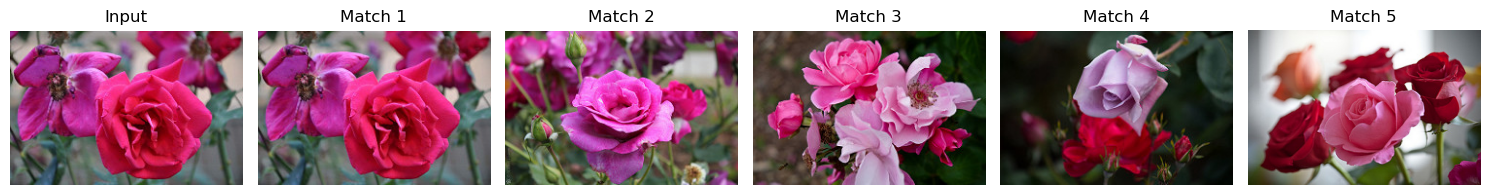


Searching for: flowers\rose\18302701228_2b5790b199_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


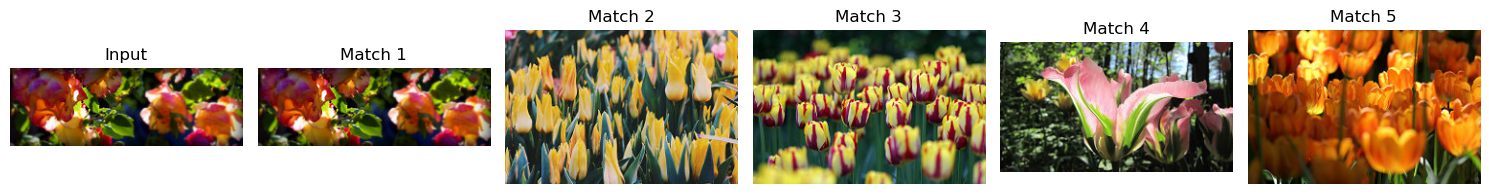


Searching for: flowers\rose\12238827553_cf427bfd51_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


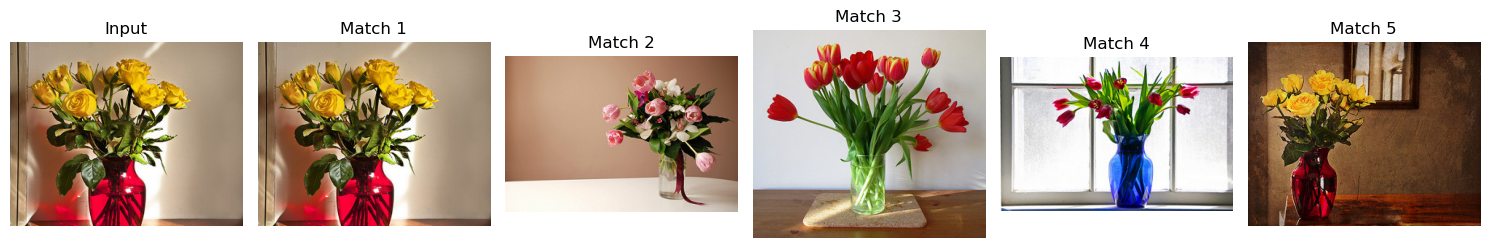

In [22]:
def plot_matches(input_path, match_paths):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(image.load_img(input_path))
    plt.title("Input")
    plt.axis('off')

    for i, path in enumerate(match_paths):
        plt.subplot(1, 6, i + 2)
        plt.imshow(image.load_img(path))
        plt.title(f"Match {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick 5 random images
random.seed(42)
test_samples = random.sample(image_paths, 5)

for sample in test_samples:
    print(f"\nSearching for: {sample}")
    result = find_similar_images(sample, model, features_array, image_paths)
    match_paths = list(result.keys())
    plot_matches(sample, match_paths)